# Pre-Processing Weather Station Data

## Table of Contents
1. [Load in Data](#1-load-in-data)
2. [Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
3. [Feature Engineering and Pre-Processing](#3-feature-engineering-and-pre-processing)
4. [Frequency](#4-frequency)
5. [Saving New Data File](#5-saving-new-data-file)

### 1. Load in Data
- **Objective**: Load the dataset for pre-processing.  
- **Instructions**:  
  Include a commented-out section of code that demonstrates how to load the data from the internet. This will allow the instructor to run the code if needed.

### 2. Exploratory Data Analysis (EDA)
- **Objective**: Examine the weather station data to identify areas requiring pre-processing or feature engineering.
- **Steps**:
  1. Use `.transpose().describe()` to summarize key statistics.
  2. Highlight any `NaN` values in the dataset.
  3. Visualize key variables:
      - Wind Direction and Wind Speed
      - Other relevant weather variables

### 3. Feature Engineering and Pre-Processing
- **Objective**: Prepare the data for a time series model by engineering and cleaning features.
- **Steps**:
  1. **Creating Missing 52nd Minute Rows**:
     - Generate rows for the 52nd minute if missing and fill them with `NaN` values.
  2. **Cloud Data Pre-Processing**:
     - Convert the 3 cloud cover columns to numeric while retaining the original columns.
     - **Interpolation**:
       - Explain reasoning for interpolation (e.g., random `NaN` instances, longest gaps).
       - Interpolate all values, focusing on the 52nd minute rows.
     - **Reducing Cloud Cover Columns**:
       - Reduce 3 cloud cover and 3 cloud height columns into 2:
         - If clear, set both columns to `0`.
         - For 1 cloud set, use its value and height.
         - For 2+ cloud sets, take the larger value for cloud cover and an average (weighted for fuller sky cover).
  3. **Visualizations**:
     - Graph cloud cover over time or other relevant visualizations.
  4. **Filling NaN Values**:
     - Use forward/backward fill for most columns rather than mean-based methods.
  5. **Additional Feature Engineering**:
     - Combine wind direction and wind speed as needed.
     - Convert precipitation from mm to inches (if necessary).

### 4. Frequency
- **Objective**: Ensure the model has access to the most relevant frequency features for accurate predictions.

### 5. Scaling and Normalizing the Data
- **Objective**: Scale and normalize the data to prepare it for machine learning models.

### 6. Training and Testing Split of the Data
- **Objective**: Split the dataset into training and testing subsets.

### 7. Saving New Data File
- **Objective**: Save the processed dataset for future use.

# 1-load-in-data
I am using hourly data from a single weather station in Kansas.

In [2]:
# Packages for this notebook
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load in the dataset from the internet
# url = "https://www.ncei.noaa.gov/oa/global-historical-climatology-network/index.html#hourly/access/by-station/GHCNh_USW00013985_por.psv"
# df = pd.read_csv(url, delimiter='|')

# I downloaded the dataset directly
usc_station_path_2 = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/GHCNh_USW00013985_por.psv'
USW00013985 = pd.read_csv(usc_station_path_2, sep='|', low_memory=False)


In [3]:
# Columns I'll be using
useful_columns = [
    'Year', 'Month', 'Day', 'Hour', 'Minute', 'temperature', 'dew_point_temperature', 
    'wet_bulb_temperature', 'station_level_pressure', 'sea_level_pressure', 
    'wind_direction', 'wind_speed', 'wind_gust', 'relative_humidity', 'precipitation',
    'sky_cover_1', 'sky_cover_2', 'sky_cover_3', 'sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_baseht_3',
    'visibility'
]
# Subsetting to only include 2011 to 2016
USW00013985 = USW00013985[(USW00013985['Year'] >= 2011) & (USW00013985['Year'] <= 2016)][useful_columns]
# Creating our Datetime column
USW00013985['Datetime'] = pd.to_datetime(USW00013985[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# Dropping the columns we used to make the Datetime column
USW00013985.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
# Preference to make Datetime first column for now
USW00013985 = USW00013985[['Datetime'] + [col for col in USW00013985.columns if col != 'Datetime']]
print(USW00013985)

                  Datetime  temperature  dew_point_temperature  \
674454 2011-01-01 00:00:00        -13.3                  -19.4   
674455 2011-01-01 00:52:00        -15.0                  -20.0   
674456 2011-01-01 01:52:00        -14.4                  -19.4   
674457 2011-01-01 02:52:00        -14.4                  -20.0   
674458 2011-01-01 03:00:00        -14.4                  -20.0   
...                    ...          ...                    ...   
757039 2016-12-31 20:52:00         15.6                   -8.3   
757040 2016-12-31 21:00:00         15.6                   -8.3   
757041 2016-12-31 21:52:00          NaN                    NaN   
757042 2016-12-31 22:52:00          NaN                    NaN   
757043 2016-12-31 23:52:00          1.1                   -8.9   

        wet_bulb_temperature  station_level_pressure  sea_level_pressure  \
674454                 -14.5                   920.4              1016.0   
674455                 -15.9                   921.2   

# 2-exploratory-data-analysis-eda

In [4]:
USW00013985.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Datetime,82590,2014-01-08 08:05:25.997820672,2011-01-01 00:00:00,2012-07-09 23:54:00,2014-01-16 12:26:00,2015-07-04 14:58:00,2016-12-31 23:52:00,NaN
temperature,82532.0,12.479366,-26.1,3.0,13.3,21.7,43.3,11.978789
dew_point_temperature,82534.0,4.008844,-28.9,-3.9,3.9,13.0,23.0,9.971921
wet_bulb_temperature,82359.0,8.143024,-26.4,0.7,8.9,16.7,24.9,9.484977
station_level_pressure,82394.0,924.461579,897.9,920.5,924.6,928.7,954.7,6.574302
sea_level_pressure,69807.0,1015.184744,984.8,1009.8,1014.8,1020.3,1052.6,8.196101
wind_direction,79450.0,187.651479,10.0,130.0,180.0,260.0,999.0,106.518471
wind_speed,82376.0,5.74491,0.0,3.6,5.1,7.7,28.0,3.023931
wind_gust,16927.0,13.31679,0.0,11.3,12.9,14.9,30.9,3.21802
relative_humidity,82532.0,62.499964,3.0,44.0,65.0,83.0,100.0,23.38576


The statistics on my dataset so far look, there were just a few things I took note of:
* Wind direction is suppose to be 0 - 360 degrees, but the max value is 999, indicating we'll have to remove and interpolate some entries
* Precipitations max value compared to its average is very large, which means it might alter the scaling for all of our data


In [5]:
features = [
    'temperature', 'dew_point_temperature', 'wet_bulb_temperature', 'station_level_pressure', 
    'sea_level_pressure', 'wind_direction', 'wind_speed', 'wind_gust', 
    'relative_humidity', 'precipitation','sky_cover_1', 'sky_cover_2', 'sky_cover_3', 
    'sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_baseht_3', 'visibility'
]

# Value for all the rows in my dataset
num_rows = len(USW00013985) 

# Calculating how many rows I should have, if I only want entires every hour
start_date = pd.Timestamp("2011-01-01 00:52:00")
end_date = pd.Timestamp("2016-12-31 23:52:00")
expected_hours = pd.date_range(start=start_date, end=end_date, freq='h').shape[0]

# After findnig that most entries are for either the 52nd or 00 minute, I want to compare them
# to see which minute on the hour I would want to use
entries_00 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 0, features].notna().sum()
entries_52 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52, features].notna().sum()

# Print the results
print(f"Number of rows in the DataFrame: {num_rows}")
print(f"Rows I should have: {expected_hours}")
print("\nEntries for each feature at the 00 minte:")
print(entries_00)
print("\nEntries for each feature at the 52 minte:")
print(entries_52)

Number of rows in the DataFrame: 82590
Rows I should have: 52608

Entries for each feature at the 00 minte:
temperature               17693
dew_point_temperature     17695
wet_bulb_temperature      17579
station_level_pressure    17590
sea_level_pressure        17374
wind_direction            17115
wind_speed                17585
wind_gust                  1058
relative_humidity         17693
precipitation               107
sky_cover_1                5401
sky_cover_2                 113
sky_cover_3                  47
sky_cover_baseht_1          227
sky_cover_baseht_2           91
sky_cover_baseht_3           47
visibility                  239
dtype: int64

Entries for each feature at the 52 minte:
temperature               52534
dew_point_temperature     52534
wet_bulb_temperature      52491
station_level_pressure    52509
sea_level_pressure        52394
wind_direction            50506
wind_speed                52499
wind_gust                 12377
relative_humidity         52534
prec

### Analysis of Minute Selection for Hourly Data

After analyzing the data, I identified two main minutes on the hour that tend to have the majority of entries:

- **52nd minute**  
- **00 minute**

Since my goal is to prepare evenly spaced, hourly data for a time series classification model, I need to choose a specific minute to standardize across the dataset. Based on the results:

1. The **52nd minute** had more entries than the 00 minute for most hours (2011–2016).
2. However, a few hours lacked entries for the 52nd minute.

To address these gaps, I will **interpolate missing values** for the 52nd minute. Later in this notebook, I’ll present my reasoning and methodology for performing this interpolation.


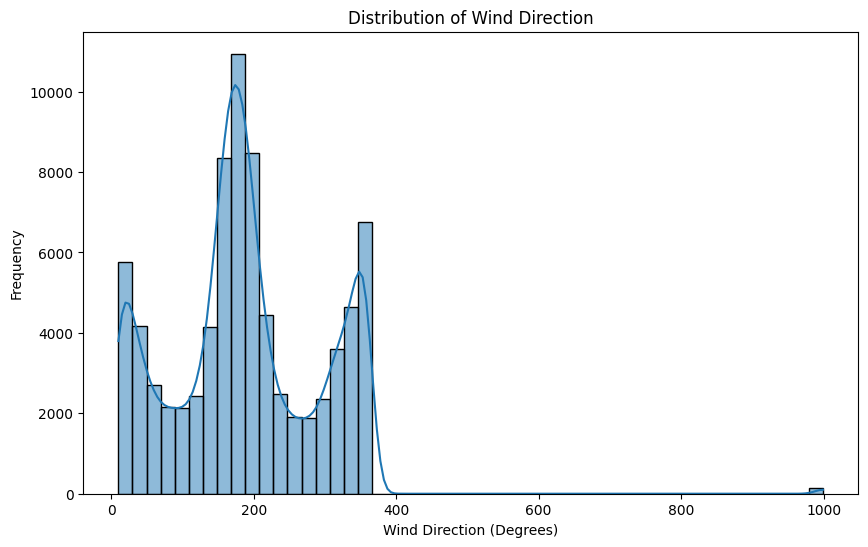

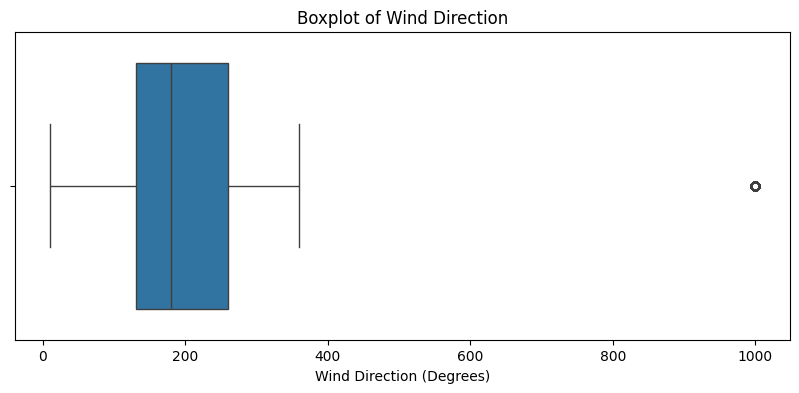

In [6]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(USW00013985['wind_direction'], bins=50, kde=True)
plt.title('Distribution of Wind Direction')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=USW00013985['wind_direction'])
plt.title('Boxplot of Wind Direction')
plt.xlabel('Wind Direction (Degrees)')
plt.show()

### Wind direction
Fixing the 999 outlier, then changing the formatting from 0 - 360 degrees, into a Wx, and Wy column, for wind speed in x direction or wind direction in y direction.

### Other columns?

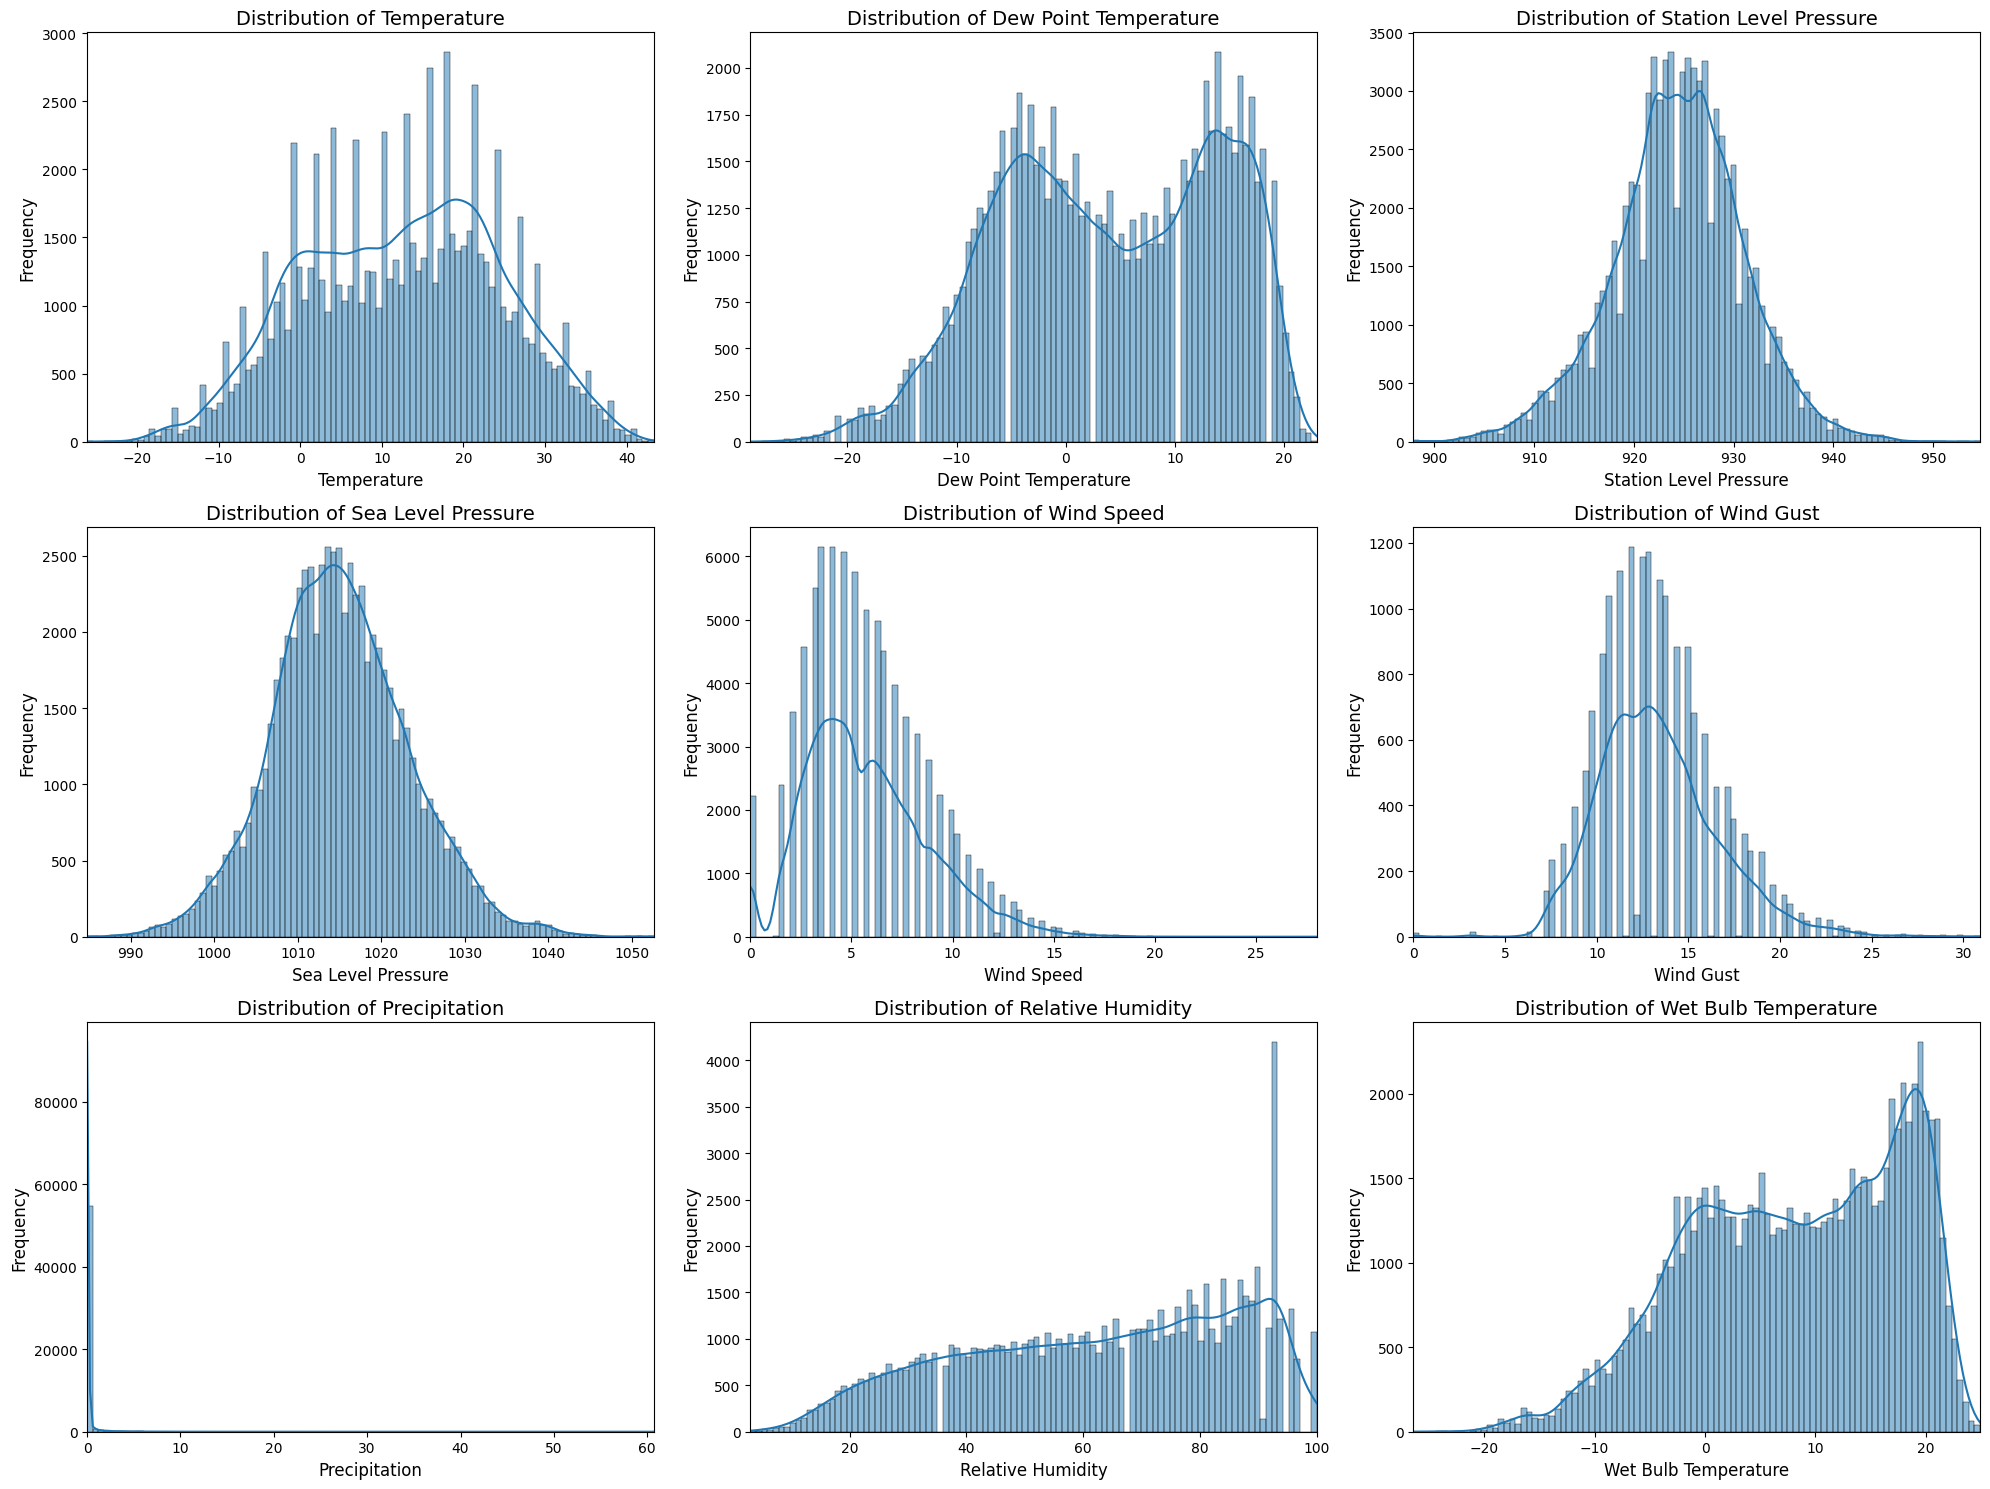

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Showing a plot of my other weather features
columns_to_plot = [
    'temperature', 'dew_point_temperature', 'station_level_pressure', 'sea_level_pressure',
    'wind_speed', 'wind_gust', 'precipitation', 'relative_humidity', 'wet_bulb_temperature'
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten() 

# for loop to create a plot for each feature
for idx, col in enumerate(columns_to_plot):
    sns.histplot(data=USW00013985, x=col, bins=100, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', fontsize=14)
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].tick_params(axis='both', which='major', labelsize=10)
    # set so even outliers are visible
    axes[idx].set_xlim(USW00013985[col].min(), USW00013985[col].max())

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

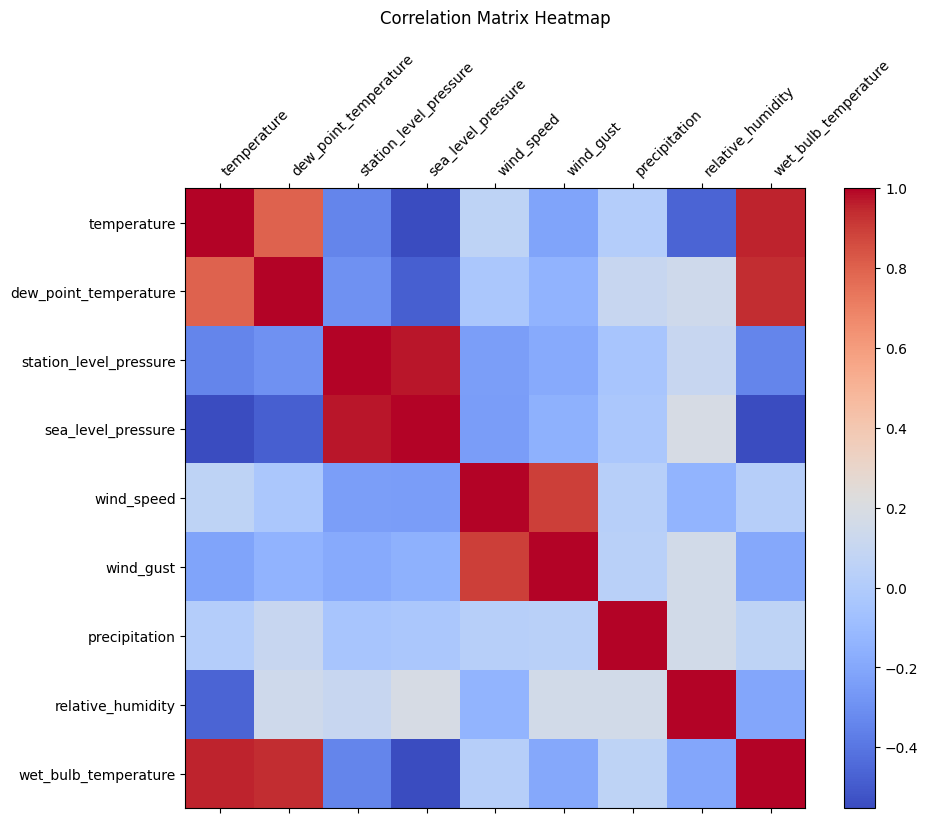

In [8]:
# Compute the correlation matrix
features = columns_to_plot
correlation_matrix = USW00013985[features].corr()

plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(features)), features, rotation=45, ha='left')
plt.yticks(range(len(features)), features)
plt.title("Correlation Matrix Heatmap", pad=20)
plt.show()

# 3-feature-engineering-and-pre-processing

## Creating rows for the 52nd minute

In [32]:
import pandas as pd

# Defining the start and end of my entire dataset
start_date = pd.Timestamp("2011-01-01 00:52:00")
end_date = pd.Timestamp("2016-12-31 23:52:00")

# Finding how many entries I want for the 52nd minute
expected_timestamps_52 = pd.date_range(start=start_date, end=end_date, freq='h')

# Finding how many entries I already have for the 52nd minute
actual_timestamps_52 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52, 'Datetime']
actual_52_len = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52, 'Datetime'].shape[0]

# Variable to hold which entries I missing
missing_timestamps_52 = set(expected_timestamps_52) - set(actual_timestamps_52)

# Creating a DataFrame for the missing rows, filling new entries with NaNs
missing_rows = pd.DataFrame({
    'Datetime': list(missing_timestamps_52)
})
for feature in features:
    missing_rows[feature] = pd.NA

# Adding these new entries into my origianl dataset
USW00013985 = pd.concat([USW00013985, missing_rows], ignore_index=True)

# Making sure my dataset if sorted by time
USW00013985 = USW00013985.sort_values(by='Datetime').reset_index(drop=True)

# Calculate the actual and expected number of rows in the dataset for the 52nd minute
expected_rows_52 = pd.date_range(start=start_date, end=end_date, freq='h').shape[0]
actual_rows_52 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52].shape[0]

# Printing comparisons
print(f"Rows for the 52nd minute before any changes: {actual_52_len}")
print(f"Expected number of rows for the 52nd minute: {expected_rows_52}")
print(f"Added {len(missing_timestamps_52)} missing rows for the 52nd minute.")
print(f"Actual number of rows for the 52nd minute now: {actual_rows_52}")

Rows for the 52nd minute before any changes: 52608
Expected number of rows for the 52nd minute: 52608
Added 0 missing rows for the 52nd minute.
Actual number of rows for the 52nd minute now: 52608


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_7905/869808791.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  USW00013985 = pd.concat([USW00013985, missing_rows], ignore_index=True)


## Reasoning for cloud cover interpolation method and feature engineering



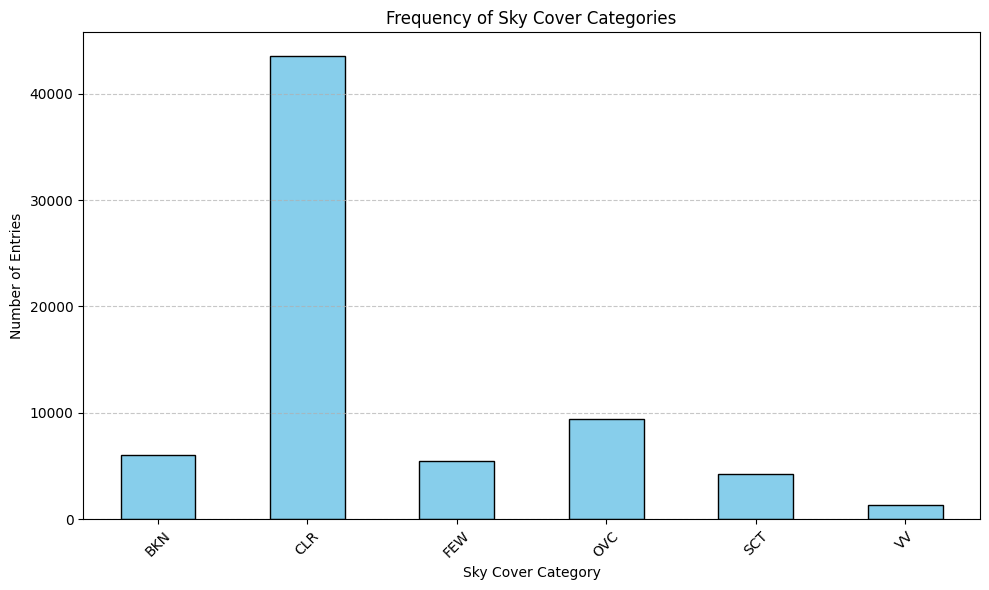

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with your actual DataFrame)
# USW00013985 = pd.read_csv('your_data.csv')

# Extract the code numbers from 'sky_cover_1'
USW00013985['sky_cover_code'] = USW00013985['sky_cover_1'].str.split(':').str[-1]

# Map codes to descriptions
code_to_description = {
    '00': 'CLR',
    '01': 'FEW',
    '02': 'FEW',
    '03': 'SCT',
    '04': 'SCT',
    '05': 'BKN',
    '06': 'BKN',
    '07': 'BKN',
    '08': 'OVC',
    '09': 'VV',
    '10': 'X'    # Unknown or missing data
}

USW00013985['sky_cover_description'] = USW00013985['sky_cover_code'].map(code_to_description)

# Count the occurrences of each category
category_counts = USW00013985['sky_cover_description'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Sky Cover Categories')
plt.xlabel('Sky Cover Category')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
import random

columns_to_display = ['Datetime', 'sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_2', 
                      'sky_cover_1',]

# Finding entries for out 52nd minute where there are Nan values
filtered_indices = USW00013985[(USW00013985['Datetime'].dt.minute == 52) & 
                               (USW00013985['sky_cover_1'].isna())].index

if len(filtered_indices) > 0:
    # taking a random selection, so I can run this cell again and see different examples
    random_nan_index = random.choice(filtered_indices)
    
    start_index = max(0, random_nan_index - 4) 
    end_index = min(len(USW00013985), random_nan_index + 6)  # starting index is positive and inbounds
    surrounding_rows = USW00013985.iloc[start_index:end_index][columns_to_display]
    
    print(f"5 rows surrounding the random NaN entry at index {random_nan_index}:")
    print(surrounding_rows)
else:
    print("No missing values.")



5 rows surrounding the random NaN entry at index 67950:
                 Datetime  sky_cover_baseht_1  sky_cover_baseht_2 sky_cover_2  \
67946 2015-12-07 01:52:00                 0.0                 NaN         NaN   
67947 2015-12-07 02:52:00                 0.0                 NaN         NaN   
67948 2015-12-07 03:00:00                 NaN                 NaN         NaN   
67949 2015-12-07 03:52:00                 0.0                 NaN         NaN   
67950 2015-12-07 04:52:00                 0.0                 NaN         NaN   
67951 2015-12-07 05:52:00                 0.0                 NaN         NaN   
67952 2015-12-07 06:00:00                 NaN                 NaN         NaN   
67953 2015-12-07 06:52:00                 0.0                 NaN         NaN   
67954 2015-12-07 07:52:00                 0.0                 NaN         NaN   
67955 2015-12-07 08:52:00                 0.0                 NaN         NaN   

      sky_cover_1  
67946         NaN  
67947       

### Biggest gaps

In [45]:
import pandas as pd
import numpy as np

# Step 1: Ensure 'Datetime' is in datetime format
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])

# Step 2: Find the minimum and maximum datetime
min_datetime = USW00013985['Datetime'].min().floor('H')
max_datetime = USW00013985['Datetime'].max().ceil('H')

# Step 3: Create a date range with hourly frequency at the 52nd minute
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H') + pd.Timedelta(minutes=52)

# Step 4: Create a DataFrame with the complete time index
df_full_52 = pd.DataFrame({'Datetime': date_range})

# Step 5: Merge the complete time index with your original data
df_full_52 = df_full_52.merge(USW00013985, on='Datetime', how='left')

# Step 6: Ensure only entries at the 52nd minute are included
df_full_52 = df_full_52[df_full_52['Datetime'].dt.minute == 52].copy()

# Step 7: Sort by 'Datetime' and reset index
df_full_52 = df_full_52.sort_values(by='Datetime').reset_index(drop=True)

# Step 8: Identify non-NaN entries of 'sky_cover_1'
non_nan_sky_cover = df_full_52[df_full_52['sky_cover_1'].notna()].copy()

# Step 9: Calculate time differences between consecutive non-NaN entries
non_nan_sky_cover['time_diff'] = non_nan_sky_cover['Datetime'].diff()

# Step 10: Find the top 5 largest gaps
top_5_gaps = non_nan_sky_cover['time_diff'].nlargest(5)

# Step 11: Print the results
print("Top 5 biggest gaps between non-NaN values for 'sky_cover_1' at the 52nd minute:")
for idx in top_5_gaps.index:
    if idx == 0:
        continue  # Skip the first entry since diff() returns NaT
    gap_duration = non_nan_sky_cover.loc[idx, 'time_diff']
    gap_start = non_nan_sky_cover.loc[idx - 1, 'Datetime']
    gap_end = non_nan_sky_cover.loc[idx, 'Datetime']
    print(f"Gap Duration: {gap_duration}, Start: {gap_start}, End: {gap_end}")



/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_7905/2907155325.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  min_datetime = USW00013985['Datetime'].min().floor('H')
/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_7905/2907155325.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  max_datetime = USW00013985['Datetime'].max().ceil('H')
/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_7905/2907155325.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H') + pd.Timedelta(minutes=52)


Top 5 biggest gaps between non-NaN values for 'sky_cover_1' at the 52nd minute:


KeyError: 43244

In [43]:
# Define the start and end time
start_time = "2011-12-19 21:52:00"
end_time = "2011-12-20 11:52:00"

# Filter rows based on the given start and end time
filtered_rows = USW00013985[
    (USW00013985['Datetime'] >= start_time) & 
    (USW00013985['Datetime'] <= end_time)
]

# Print the 'Datetime' and 'sky_cover_1' columns
print(filtered_rows[['Datetime', 'sky_cover_1', 'sky_cover_baseht_1']])


                 Datetime sky_cover_1  sky_cover_baseht_1
13131 2011-12-19 21:52:00         NaN                 NaN
13132 2011-12-19 21:59:00         NaN                 NaN
13133 2011-12-19 22:29:00      OVC:08               183.0
13134 2011-12-19 22:42:00      OVC:08               183.0
13135 2011-12-19 22:52:00      OVC:08               183.0
13136 2011-12-19 23:06:00      OVC:08               183.0
13137 2011-12-19 23:44:00      BKN:07               244.0
13138 2011-12-19 23:50:00      BKN:07               183.0
13139 2011-12-19 23:52:00      BKN:07               183.0
13140 2011-12-20 00:00:00         NaN                 NaN
13141 2011-12-20 00:52:00      OVC:08               183.0
13142 2011-12-20 01:15:00      OVC:08               183.0
13143 2011-12-20 01:25:00      OVC:08               183.0
13144 2011-12-20 01:34:00      OVC:08               183.0
13145 2011-12-20 01:52:00      OVC:08               183.0
13146 2011-12-20 02:08:00      BKN:07               183.0
13147 2011-12-

# Interpolating values for cloud cover

In [14]:
import pandas as pd
import numpy as np

# Mapping from code numbers to fractions
code_to_fraction = {
    '00': 0.0,    # CLR
    '01': 0.125,  # FEW
    '02': 0.25,   # FEW
    '03': 0.375,  # SCT
    '04': 0.5,    # SCT
    '05': 0.625,  # BKN
    '06': 0.75,   # BKN
    '07': 0.875,  # BKN
    '08': 1.0,    # OVC
    '09': 1.0,    # VV
    '10': np.nan  # X (unknown or missing data)
}

def sky_cover_code_to_fraction(sky_cover_entry):
    if pd.isna(sky_cover_entry):
        return np.nan
    try:
        code_number = sky_cover_entry.split(':')[-1]
        fraction = code_to_fraction.get(code_number, np.nan)
        return fraction
    except Exception:
        return np.nan

fraction_to_code = {v: k for k, v in code_to_fraction.items() if not np.isnan(v)}
sorted_fractions = sorted(fraction_to_code.keys())

def fraction_to_sky_cover_code(fraction):
    if np.isnan(fraction):
        return np.nan
    closest_fraction = min(sorted_fractions, key=lambda x: abs(x - fraction))
    code_number = fraction_to_code[closest_fraction]
    code_to_description = {
        '00': 'CLR',
        '01': 'FEW',
        '02': 'FEW',
        '03': 'SCT',
        '04': 'SCT',
        '05': 'BKN',
        '06': 'BKN',
        '07': 'BKN',
        '08': 'OVC',
        '09': 'VV',
        '10': 'X'    # Unknown or missing data
    }
    description = code_to_description.get(code_number, 'Unknown')
    return f"{description}:{code_number}"

def convert_sky_cover_columns_to_fraction(df, sky_cover_columns):
    for col in sky_cover_columns:
        df[col + '_fraction'] = df[col].apply(sky_cover_code_to_fraction)
    return df

def interpolate_sky_cover_fraction(df, fraction_column_name):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    df_52 = df[df.index.minute == 52].copy()
    df_52[fraction_column_name] = df_52[fraction_column_name].interpolate(method='time')
    df.update(df_52)
    df.reset_index(inplace=True)
    return df

def convert_fraction_to_sky_cover_code(df, fraction_column_name, sky_cover_column_name):
    df[sky_cover_column_name] = df[fraction_column_name].apply(fraction_to_sky_cover_code)
    return df

# Assume USW00013985 is your DataFrame
# Ensure 'Datetime' is in datetime format and sort the DataFrame
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985 = USW00013985.sort_values(by='Datetime').reset_index(drop=True)

# Step 1: Convert Sky Cover Codes to Fractions
sky_cover_columns = ['sky_cover_1', 'sky_cover_2', 'sky_cover_3']
USW00013985 = convert_sky_cover_columns_to_fraction(USW00013985, sky_cover_columns)

# Step 2: Interpolate Missing Fractions on the 52nd Minute
USW00013985 = interpolate_sky_cover_fraction(USW00013985, 'sky_cover_1_fraction')

# Step 3: Convert Interpolated Fractions Back to Sky Cover Codes
USW00013985 = convert_fraction_to_sky_cover_code(
    USW00013985, 'sky_cover_1_fraction', 'sky_cover_1_interpolated')

# Step 4: (Optional) Convert 'sky_cover_1_interpolated' Back to Fractions
USW00013985['sky_cover_1_interpolated_fraction'] = USW00013985['sky_cover_1_interpolated'].apply(
    sky_cover_code_to_fraction)

# Step 5: Ensure 'CLR:00' corresponds to base height 0
USW00013985.loc[USW00013985['sky_cover_1_interpolated'] == 'CLR:00', 'sky_cover_baseht_1'] = 0

# Display specific rows to verify
print(USW00013985[['Datetime', 'sky_cover_1', 'sky_cover_1_fraction',
                   'sky_cover_1_interpolated', 'sky_cover_1_interpolated_fraction']].iloc[82154:82163])


                 Datetime sky_cover_1  sky_cover_1_fraction  \
82154 2016-12-17 18:47:00       VV:09                 1.000   
82155 2016-12-17 18:52:00       VV:09                 1.000   
82156 2016-12-17 19:31:00       VV:09                 1.000   
82157 2016-12-17 19:40:00       VV:09                 1.000   
82158 2016-12-17 19:52:00       VV:09                 1.000   
82159 2016-12-17 20:00:00      OVC:08                 1.000   
82160 2016-12-17 20:11:00      BKN:07                 0.875   
82161 2016-12-17 20:33:00      FEW:02                 0.250   
82162 2016-12-17 20:46:00      FEW:02                 0.250   

      sky_cover_1_interpolated  sky_cover_1_interpolated_fraction  
82154                    VV:09                              1.000  
82155                    VV:09                              1.000  
82156                    VV:09                              1.000  
82157                    VV:09                              1.000  
82158                    VV:0

In [16]:
# Define the start and end time

#Gap: 1 days 01:00:00, Start: 2015-12-06 20:52:00, End: 2015-12-07 21:52:00
#Gap: 0 days 09:00:00, Start: 2014-11-16 09:52:00, End: 2014-11-16 18:52:00
#Gap: 0 days 08:00:00, Start: 2013-05-31 22:52:00, End: 2013-06-01 06:52:00

start_time = "2014-11-16 06:52:00"
end_time = "2014-11-16 22:52:00"

# Filter rows based on the given start and end time
filtered_rows = USW00013985[
    (USW00013985['Datetime'] >= start_time) & 
    (USW00013985['Datetime'] <= end_time)
]

# Print the 'Datetime' and 'sky_cover_1' columns
print(filtered_rows[['Datetime', 'sky_cover_1', 'sky_cover_1_fraction',
                   'sky_cover_1_interpolated', 'sky_cover_1_interpolated_fraction']])

                 Datetime sky_cover_1  sky_cover_1_fraction  \
52722 2014-11-16 06:52:00      OVC:08              1.000000   
52723 2014-11-16 06:59:00         NaN                   NaN   
52724 2014-11-16 07:05:00      OVC:08              1.000000   
52725 2014-11-16 07:44:00      SCT:04              0.500000   
52726 2014-11-16 07:52:00      FEW:02              0.250000   
52727 2014-11-16 08:41:00      OVC:08              1.000000   
52728 2014-11-16 08:50:00      OVC:08              1.000000   
52729 2014-11-16 08:52:00      OVC:08              1.000000   
52730 2014-11-16 09:24:00      OVC:08              1.000000   
52731 2014-11-16 09:43:00       VV:09              1.000000   
52732 2014-11-16 09:50:00       VV:09              1.000000   
52733 2014-11-16 09:52:00       VV:09              1.000000   
52734 2014-11-16 10:07:00       VV:09              1.000000   
52735 2014-11-16 10:16:00         NaN                   NaN   
52736 2014-11-16 10:52:00         NaN              0.94

In [28]:
print(USW00013985['sky_cover_1_fraction'].shape)
print(USW00013985['sky_cover_1_interpolated_fraction'].shape)

(82646,)
(82646,)


In [ ]:
# Replace values in 'sky_cover_1_fraction' with those from 'sky_cover_1_interpolated_fraction'
USW00013985['sky_cover_1_fraction'] = USW00013985['sky_cover_1_interpolated_fraction']


No missing values at the 52nd minute in 'sky_cover_1_interpolated_fraction'.


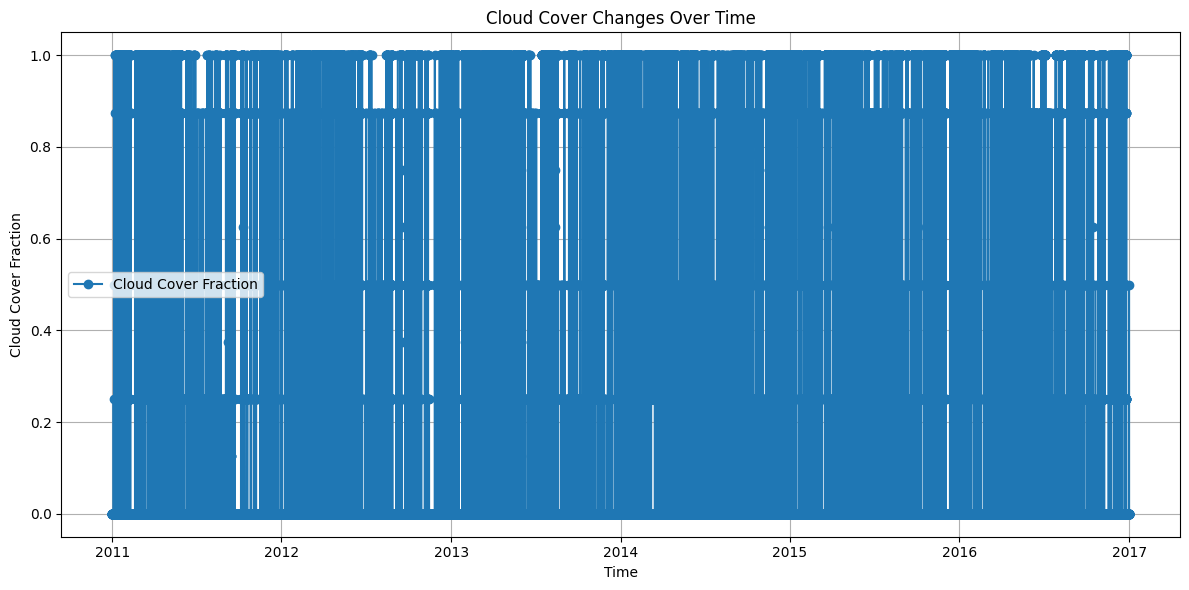

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Check for missing values in 'sky_cover_1_interpolated_fraction' at the 52nd minute
nan_entries_52nd_minute = USW00013985[
    (USW00013985['Datetime'].dt.minute == 52) & 
    (USW00013985['sky_cover_1_interpolated_fraction'].isna())
]

# Print the missing entries
if not nan_entries_52nd_minute.empty:
    print("Missing values at the 52nd minute in 'sky_cover_1_interpolated_fraction':")
    print(nan_entries_52nd_minute[['Datetime', 'sky_cover_1_interpolated_fraction']])
else:
    print("No missing values at the 52nd minute in 'sky_cover_1_interpolated_fraction'.")

# Plotting cloud cover changes over time
plt.figure(figsize=(12, 6))
plt.plot(USW00013985['Datetime'], USW00013985['sky_cover_1_interpolated_fraction'], label='Cloud Cover Fraction', linestyle='-', marker='o')
plt.title('Cloud Cover Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Cloud Cover Fraction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


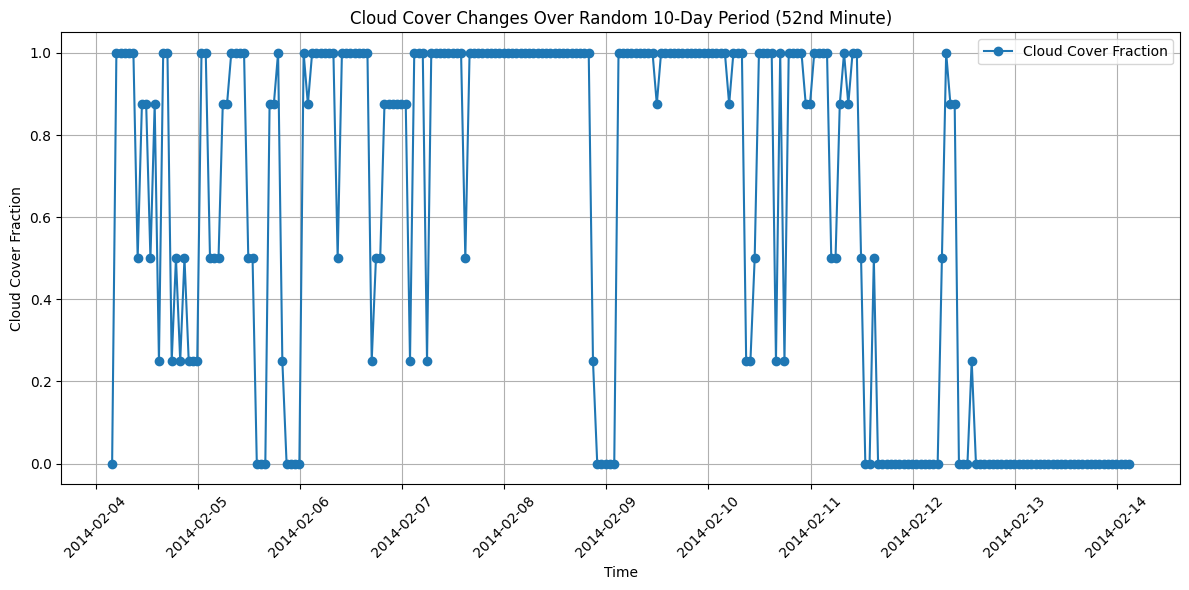

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter the dataset for entries at the 52nd minute
data_52nd_minute = USW00013985[USW00013985['Datetime'].dt.minute == 52]

# Select a random 10-day subsection
start_idx = np.random.randint(0, len(data_52nd_minute) - 240)  # Approx 10 days of hourly data
end_idx = start_idx + 240  # Assuming ~24 entries per day (1 entry per hour)
random_10_day_section = data_52nd_minute.iloc[start_idx:end_idx]

# Plot the 10-day subsection
plt.figure(figsize=(12, 6))
plt.plot(random_10_day_section['Datetime'], random_10_day_section['sky_cover_1_interpolated_fraction'], 
         label='Cloud Cover Fraction', linestyle='-', marker='o')
plt.title('Cloud Cover Changes Over Random 10-Day Period (52nd Minute)')
plt.xlabel('Time')
plt.ylabel('Cloud Cover Fraction')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Dimenstionality reduction for Cloud Cover and Base Height

In [10]:
# Specify the columns to include
columns_to_include = [
    'Year', 'Month', 'Day', 'Hour', 'Minute',
    'sky_cover_1', 'sky_cover_2', 'sky_cover_3',
    'sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_baseht_3'
]

# Print the first 5 rows after the 10,000th entry
print("Rows 10,001 to 10,005:")
print(USW00013985.iloc[10000:10005][columns_to_include])

# Print the first 5 rows after the 10,200th entry
print("Rows 10,201 to 10,205:")
print(USW00013985.iloc[10200:10205][columns_to_include])

# Print the first 5 rows after the 10,400th entry
print("Rows 10,401 to 10,305:")
print(USW00013985.iloc[10400:10405][columns_to_include])

# Print the first 5 rows after the 11,000th entry
print("\nRows 11,001 to 11,005:")
print(USW00013985.iloc[11000:11005][columns_to_include])



Rows 10,001 to 10,005:
        Year  Month  Day  Hour  Minute sky_cover_1 sky_cover_2 sky_cover_3  \
684454  2011      9   27    12      52      CLR:00         NaN         NaN   
684455  2011      9   27    13      52      CLR:00         NaN         NaN   
684456  2011      9   27    14      52      CLR:00         NaN         NaN   
684457  2011      9   27    15       0      CLR:00         NaN         NaN   
684458  2011      9   27    15      52      CLR:00         NaN         NaN   

        sky_cover_baseht_1  sky_cover_baseht_2  sky_cover_baseht_3  
684454                 0.0                 0.0                 0.0  
684455                 0.0                 0.0                 0.0  
684456                 0.0                 0.0                 0.0  
684457                 0.0                 0.0                 0.0  
684458                 0.0                 0.0                 0.0  
Rows 10,201 to 10,205:
        Year  Month  Day  Hour  Minute sky_cover_1 sky_cover_2 sky_cove

In [6]:
def preprocess_sky_cover(df):
    """
    Processes the sky_cover and sky_cover_baseht columns in the DataFrame in place.
    Calculates normalized total sky cover and average cloud base height.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing sky_cover_* and sky_cover_baseht_* columns.
    """
    # Mapping of sky_cover codes to numerical values
    sky_cover_mapping = {
        0: 0,    # CLR:00
        1: 1,    # FEW:01
        2: 2,    # FEW:02
        3: 3,    # SCT:03
        4: 4,    # SCT:04
        5: 5,    # BKN:05
        6: 6,    # BKN:06
        7: 7,    # BKN:07
        8: 8,    # OVC:08
        9: np.nan,  # VV:09 - Sky obscured
        10: np.nan, # X:10 - Partial obscuration
        99: np.nan  # Missing
    }
    
    def extract_code(value):
        """
        Extracts the numerical code from a sky_cover string like 'CLR:00'.
        """
        if pd.isnull(value):
            return np.nan
        else:
            try:
                code = value.split(':')[-1]
                return int(code)
            except (ValueError, AttributeError):
                return np.nan

    # Process each sky_cover_* column
    for i in range(1, 4):
        col_name = f'sky_cover_{i}'
        code_col_name = f'sky_cover_{i}_code'
        mapped_col_name = f'sky_cover_{i}_mapped'
        baseht_col_name = f'sky_cover_baseht_{i}'

        # Extract the code from the sky_cover column
        df[code_col_name] = df[col_name].apply(extract_code)

        # Map the code to numerical sky cover value
        df[mapped_col_name] = df[code_col_name].map(sky_cover_mapping)

        # If sky_cover_* is NaN, assume clear skies (sky cover = 0)
        df[mapped_col_name].fillna(0, inplace=True)

        # If sky_cover_* is 0 (clear skies), set corresponding base height to 0
        df.loc[df[mapped_col_name] == 0, baseht_col_name] = 0

    # Calculate total sky cover by summing the mapped values
    df['total_sky_cover'] = df[['sky_cover_1_mapped', 'sky_cover_2_mapped', 'sky_cover_3_mapped']].sum(axis=1)

    # Normalize total sky cover (maximum possible is 8 * 3 = 24)
    df['total_sky_cover_normalized'] = df['total_sky_cover'] / 24.0

    # Calculate average cloud base height
    # Weigh the base heights by the sky cover amount, considering only available values
    total_sky_cover_nonzero = df[['sky_cover_1_mapped', 'sky_cover_2_mapped', 'sky_cover_3_mapped']].replace(0, np.nan)

    weighted_heights = (
        df['sky_cover_1_mapped'] * df['sky_cover_baseht_1'] +
        df['sky_cover_2_mapped'] * df['sky_cover_baseht_2'] +
        df['sky_cover_3_mapped'] * df['sky_cover_baseht_3']
    )

    total_sky_cover_weight = total_sky_cover_nonzero.sum(axis=1)

    df['avg_cloud_base_height'] = weighted_heights / total_sky_cover_weight

    # Handle cases where total_sky_cover_weight is zero (no clouds)
    df['avg_cloud_base_height'].fillna(0, inplace=True)

    # Normalize average cloud base height
    max_height = df[['sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_baseht_3']].max().max()

    if max_height == 0 or pd.isnull(max_height):
        max_height = 1  # Prevent division by zero

    df['avg_cloud_base_height_normalized'] = df['avg_cloud_base_height'] / max_height

    # Clean up intermediate columns if desired
    cols_to_drop = []
    for i in range(1, 4):
        cols_to_drop.extend([
            f'sky_cover_{i}_code',
            f'sky_cover_{i}_mapped'
        ])
    cols_to_drop.append('total_sky_cover')
    cols_to_drop.append('avg_cloud_base_height')

    df.drop(columns=cols_to_drop, inplace=True)


In [7]:
# Assuming 'USW00013985' is your DataFrame
preprocess_sky_cover(USW00013985)

# Now 'USW00013985' has the new columns:
# 'total_sky_cover_normalized' and 'avg_cloud_base_height_normalized'
USW00013985.head()

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_37173/1021099800.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[mapped_col_name].fillna(0, inplace=True)
/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_37173/1021099800.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

,Year,Month,Day,Hour,Minute,temperature,dew_point_temperature,wet_bulb_temperature,station_level_pressure,sea_level_pressure,...,precipitation,sky_cover_1,sky_cover_2,sky_cover_3,sky_cover_baseht_1,sky_cover_baseht_2,sky_cover_baseht_3,visibility,total_sky_cover_normalized,avg_cloud_base_height_normalized
674454,2011,1,1,0,0,-13.3,-19.4,-14.5,920.4,1016.0,...,NaN,CLR:00,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0
674455,2011,1,1,0,52,-15.0,-20.0,-15.9,921.2,1017.2,...,0.0,CLR:00,NaN,NaN,0.0,0.0,0.0,16.093,0.0,0.0
674456,2011,1,1,1,52,-14.4,-19.4,-15.4,921.8,1017.7,...,0.0,CLR:00,NaN,NaN,0.0,0.0,0.0,16.093,0.0,0.0
674457,2011,1,1,2,52,-14.4,-20.0,-15.5,922.1,1018.5,...,0.0,CLR:00,NaN,NaN,0.0,0.0,0.0,16.093,0.0,0.0
674458,2011,1,1,3,0,-14.4,-20.0,-15.5,922.2,1018.5,...,NaN,CLR:00,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0


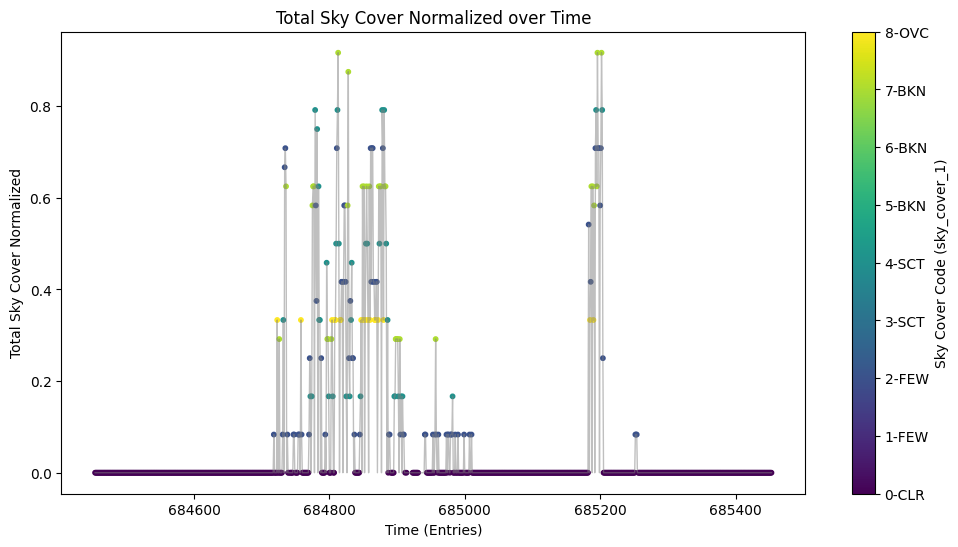

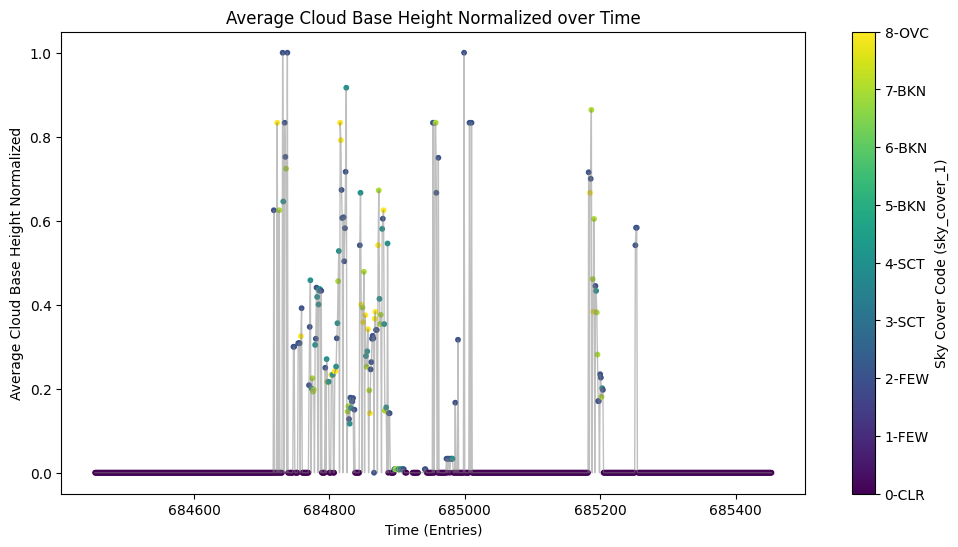

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def extract_sky_cover_code(value):
    if pd.isnull(value):
        return np.nan
    try:
        code = value.split(':')[-1]
        return int(code)
    except (ValueError, AttributeError):
        return np.nan

# Mapping from codes to coverage levels (0 to 8)
coverage_mapping = {
    0: 0,   # 00:CLR
    1: 1,   # 01:FEW
    2: 2,   # 02:FEW
    3: 3,   # 03:SCT
    4: 4,   # 04:SCT
    5: 5,   # 05:BKN
    6: 6,   # 06:BKN
    7: 7,   # 07:BKN
    8: 8,   # 08:OVC
    9: np.nan,  # 09:VV (Sky obscured)
    10: np.nan, # 10:X (Partial obscuration)
    99: np.nan  # Missing
}

# Choose one of the sky_cover columns, e.g., sky_cover_1
sky_cover_column = 'sky_cover_1'

# Process the chosen sky_cover column
USW00013985['sky_cover_code'] = USW00013985[sky_cover_column].apply(extract_sky_cover_code)
USW00013985['sky_cover_coverage'] = USW00013985['sky_cover_code'].map(coverage_mapping)

# Prepare the subset of data for plotting (first 200 entries)
df_plot = USW00013985.iloc[10000:11000].copy()

# Ensure that the required columns are present
if 'total_sky_cover_normalized' not in df_plot.columns or 'avg_cloud_base_height_normalized' not in df_plot.columns:
    raise ValueError("Required normalized columns are not present in the DataFrame.")

# Prepare the x-axis (entries or time)
x_values = df_plot.index

# Create a colormap
norm = mcolors.Normalize(vmin=0, vmax=8)
cmap = plt.cm.viridis

# Plot total_sky_cover_normalized
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    x_values,
    df_plot['total_sky_cover_normalized'],
    c=df_plot['sky_cover_coverage'],
    cmap=cmap,
    norm=norm,
    s=10
)
plt.plot(
    x_values,
    df_plot['total_sky_cover_normalized'],
    color='gray',
    linewidth=1,
    alpha=0.5
)
plt.xlabel('Time (Entries)')
plt.ylabel('Total Sky Cover Normalized')
plt.title('Total Sky Cover Normalized over Time')

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(0, 9))
cbar.set_label(f'Sky Cover Code ({sky_cover_column})')
cbar.ax.set_yticklabels(['0-CLR', '1-FEW', '2-FEW', '3-SCT', '4-SCT', '5-BKN', '6-BKN', '7-BKN', '8-OVC'])

plt.show()

# Plot avg_cloud_base_height_normalized
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    x_values,
    df_plot['avg_cloud_base_height_normalized'],
    c=df_plot['sky_cover_coverage'],
    cmap=cmap,
    norm=norm,
    s=10
)
plt.plot(
    x_values,
    df_plot['avg_cloud_base_height_normalized'],
    color='gray',
    linewidth=1,
    alpha=0.5
)
plt.xlabel('Time (Entries)')
plt.ylabel('Average Cloud Base Height Normalized')
plt.title('Average Cloud Base Height Normalized over Time')

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(0, 9))
cbar.set_label(f'Sky Cover Code ({sky_cover_column})')
cbar.ax.set_yticklabels(['0-CLR', '1-FEW', '2-FEW', '3-SCT', '4-SCT', '5-BKN', '6-BKN', '7-BKN', '8-OVC'])

plt.show()




In [20]:
# Print the first 5 rows after the 10,000th entry
print("Rows 10,001 to 10,005:")
print(USW00013985.iloc[10000:10005])

# Print the first 5 rows after the 11,000th entry
print("\nRows 11,001 to 11,005:")
print(USW00013985.iloc[11000:11005])


Rows 10,001 to 10,005:
        Year  Month  Day  Hour  Minute  temperature  dew_point_temperature  \
684454  2011      9   27    12      52          9.4                    5.0   
684455  2011      9   27    13      52         12.8                    6.1   
684456  2011      9   27    14      52         16.7                    6.7   
684457  2011      9   27    15       0         16.7                    6.7   
684458  2011      9   27    15      52         21.1                    7.2   

        wet_bulb_temperature  station_level_pressure  sea_level_pressure  ...  \
684454                   7.3                   925.5              1015.6  ...   
684455                   9.4                   926.2              1016.2  ...   
684456                  11.3                   926.5              1016.3  ...   
684457                  11.3                   926.6              1016.3  ...   
684458                  13.4                   927.1              1017.0  ...   

        sky_cover_1_c

### Do we need to change other columns?

# 4-frequency

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/1976030561.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  USW00013985_hourly = USW00013985.resample('H').mean()


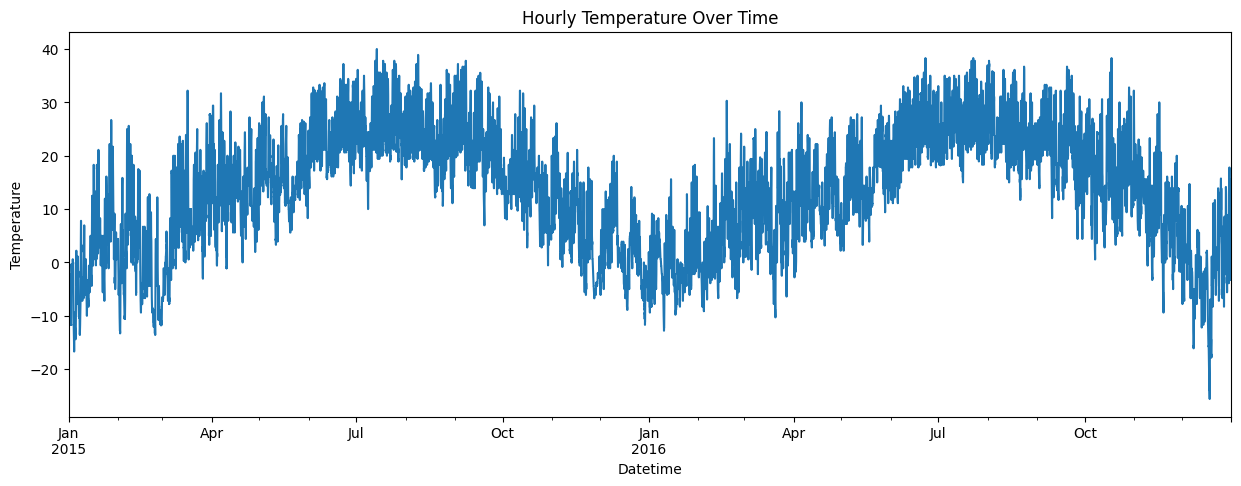

In [43]:
USW00013985 = USW00013985.set_index('Datetime')

USW00013985_hourly = USW00013985.resample('H').mean()

USW00013985_hourly = USW00013985_hourly.interpolate(method='time')

USW00013985_hourly['temperature'].plot(figsize=(15, 5))
plt.title('Hourly Temperature Over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.show()


### Fixing wind direction

In [29]:
# Display unique values and count of missing values
print("Unique Wind Direction Values:", USW00013985['wind_direction'].unique())
print("Number of Missing Values:", USW00013985['wind_direction'].isnull().sum())

# Check for negative values or values exceeding 360
invalid_high = USW00013985[USW00013985['wind_direction'] > 360]
invalid_low = USW00013985[USW00013985['wind_direction'] < 0]
print(f"Number of wind_direction > 360: {invalid_high.shape[0]}")
print(f"Number of wind_direction < 0: {invalid_low.shape[0]}")

Unique Wind Direction Values: [260. 240. 230. 250. 270. 280. 200. 220. 290. 310. 210. 330.  nan 320.
 190. 300. 340. 350. 360. 140. 130. 120. 150. 160. 170. 180.  20.  30.
 999.  40.  10. 110.  90.  50.  60. 100.  80.  70.]
Number of Missing Values: 1020
Number of wind_direction > 360: 77
Number of wind_direction < 0: 0


In [44]:
# 1. Replace invalid 'wind_direction' values with NaN
USW00013985['wind_direction'].replace(999, np.nan, inplace=True)

# 2. Interpolate 'wind_speed'
USW00013985['wind_speed'] = USW00013985['wind_speed'].interpolate(method='time')

# 3. Convert 'wind_direction' to radians
USW00013985['wind_direction_rad'] = np.deg2rad(USW00013985['wind_direction'])

# 4. Calculate sine and cosine components
USW00013985['wind_dir_sin'] = np.sin(USW00013985['wind_direction_rad'])
USW00013985['wind_dir_cos'] = np.cos(USW00013985['wind_direction_rad'])

# 5. Interpolate sine and cosine components
USW00013985['wind_dir_sin'] = USW00013985['wind_dir_sin'].interpolate(method='time')
USW00013985['wind_dir_cos'] = USW00013985['wind_dir_cos'].interpolate(method='time')

# 6. Reconstruct wind direction from interpolated components
USW00013985['wind_direction_rad'] = np.arctan2(
    USW00013985['wind_dir_sin'], USW00013985['wind_dir_cos']
)

# 7. Convert radians back to degrees
USW00013985['wind_direction'] = np.rad2deg(USW00013985['wind_direction_rad']) % 360

# 8. Compute wind x and y components
USW00013985['Wx'] = USW00013985['wind_speed'] * np.cos(USW00013985['wind_direction_rad'])
USW00013985['Wy'] = USW00013985['wind_speed'] * np.sin(USW00013985['wind_direction_rad'])

# 9. Drop intermediate columns
USW00013985.drop(['wind_dir_sin', 'wind_dir_cos', 'wind_direction_rad'], axis=1, inplace=True)


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/4262654532.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  USW00013985['wind_direction'].replace(999, np.nan, inplace=True)


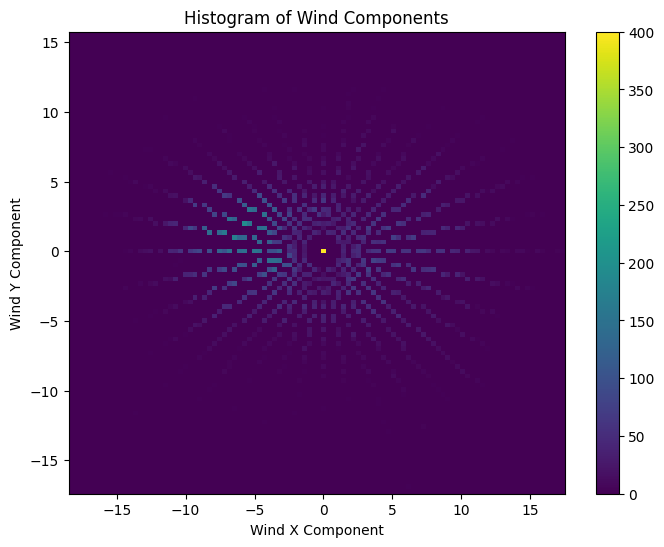

In [55]:
plt.figure(figsize=(8, 6))
plt.hist2d(USW00013985['Wx'], USW00013985['Wy'], bins=(100, 100), vmax=400)
plt.colorbar()
plt.xlabel('Wind X Component')
plt.ylabel('Wind Y Component')
plt.title('Histogram of Wind Components')
plt.show()


In [46]:
print("Number of Missing Values:", USW00013985['wind_direction'].isnull().sum())
print("Number of Missing Values:", USW00013985['wind_speed'].isnull().sum())

Number of Missing Values: 0
Number of Missing Values: 0


In [48]:
import pandas as pd

# Assuming USW00013985 DataFrame is already loaded.
# If not, you can load it using pd.read_csv, pd.read_excel, etc.
# Example:
# USW00013985 = pd.read_csv('your_file.csv')

# 1. Print the shape of the DataFrame
df_shape = USW00013985.shape
print(f"DataFrame Shape: {df_shape[0]} rows, {df_shape[1]} columns\n")

# 2. Define the list of columns to check for missing entries
columns_to_check = [
    'temperature',
    'dew_point_temperature',
    'station_level_pressure',
    'sea_level_pressure',
    'wind_direction',
    'wind_speed',
    'wind_gust',
    'precipitation',
    'relative_humidity',
    'wet_bulb_temperature',
]

# Verify that all specified columns exist in the DataFrame
missing_columns = [col for col in columns_to_check if col not in USW00013985.columns]
if missing_columns:
    print("Warning: The following columns are not in the DataFrame and will be skipped:")
    for col in missing_columns:
        print(f" - {col}")
    # Remove missing columns from the list to prevent errors
    columns_to_check = [col for col in columns_to_check if col in USW00013985.columns]

# 3. Calculate the number of missing entries for each specified column
missing_counts = USW00013985[columns_to_check].isnull().sum()

# 4. Print the missing counts in a readable format
print("Missing Entries per Column:")
for column, count in missing_counts.items():
    print(f" - {column}: {count} missing entries")



DataFrame Shape: 27894 rows, 12 columns

Missing Entries per Column:
 - temperature: 27 missing entries
 - dew_point_temperature: 27 missing entries
 - station_level_pressure: 52 missing entries
 - sea_level_pressure: 4618 missing entries
 - wind_direction: 0 missing entries
 - wind_speed: 0 missing entries
 - wind_gust: 23326 missing entries
 - precipitation: 8804 missing entries
 - relative_humidity: 27 missing entries
 - wet_bulb_temperature: 65 missing entries


In [57]:
variables_to_interpolate = ['temperature', 'dew_point_temperature', 'station_level_pressure', 
                            'sea_level_pressure', 'relative_humidity', 'wet_bulb_temperature']

for var in variables_to_interpolate:
    USW00013985[var] = USW00013985[var].interpolate(method='time')

USW00013985['wind_gust'].fillna(0, inplace=True)
USW00013985['precipitation'].fillna(0, inplace=True) 

print(USW00013985.isnull().sum())

temperature               0
dew_point_temperature     0
station_level_pressure    0
sea_level_pressure        0
wind_direction            0
wind_speed                0
wind_gust                 0
precipitation             0
relative_humidity         0
wet_bulb_temperature      0
Wx                        0
Wy                        0
dtype: int64


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/1481682164.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  USW00013985['wind_gust'].fillna(0, inplace=True)
/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/1481682164.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

# Frequency 2

In [94]:
# Calculate time differences between consecutive observations
time_diffs = USW00013985.index.to_series().diff().dropna()

# Display the full output
print(time_diffs.value_counts().sort_index().tail(20))

Datetime
0 days 00:42:00       57
0 days 00:43:00       49
0 days 00:44:00       56
0 days 00:45:00       58
0 days 00:46:00       41
0 days 00:47:00       58
0 days 00:48:00       38
0 days 00:49:00       40
0 days 00:50:00       82
0 days 00:51:00       37
0 days 00:52:00     5114
0 days 00:53:00       51
0 days 00:54:00        3
0 days 00:55:00       23
0 days 00:56:00       18
0 days 00:57:00       16
0 days 00:58:00       98
0 days 01:00:00    10224
0 days 01:02:00        1
0 days 02:00:00        1
Name: count, dtype: int64


In [102]:
# Resample to hourly frequency using the mean
USW00013985_hourly = USW00013985.resample('H').mean()
print(USW00013985_hourly.isnull().sum())
print(len(USW00013985_hourly))
print(len(USW00013985))

temperature               1
dew_point_temperature     1
station_level_pressure    1
sea_level_pressure        1
wind_direction            1
wind_speed                1
wind_gust                 1
precipitation             1
relative_humidity         1
wet_bulb_temperature      1
Wx                        1
Wy                        1
Day sin                   1
Day cos                   1
Year sin                  1
Year cos                  1
dtype: int64
17544
27894


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/3756293373.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  USW00013985_hourly = USW00013985.resample('H').mean()


In [112]:
# Filter specific time range for selected columns
missing_entries = USW00013985_hourly.loc['2015-06-02 13:00:00':'2015-06-02 15:00:00', 
                                      ['temperature', 'dew_point_temperature', 'Wy', 'Wx']]

print(missing_entries)

# Check the original data around the missing time window
# Filter specific time range for selected columns
missing_time_window = USW00013985.loc['2015-06-02 13:00:00':'2015-06-02 15:00:00', 
                                      ['temperature', 'dew_point_temperature', 'Wy', 'Wx']]

print(missing_time_window)


                     temperature  dew_point_temperature        Wy        Wx
Datetime                                                                   
2015-06-02 13:00:00        19.45                  16.95  0.581721 -6.899106
2015-06-02 14:00:00          NaN                    NaN       NaN       NaN
2015-06-02 15:00:00        24.40                  17.20 -1.163443 -6.598212
                     temperature  dew_point_temperature            Wy  \
Datetime                                                                
2015-06-02 13:29:00         18.9                   16.7  8.817457e-16   
2015-06-02 13:52:00         20.0                   17.2  1.163443e+00   

                           Wx  
Datetime                       
2015-06-02 13:29:00 -7.200000  
2015-06-02 13:52:00 -6.598212  


In [114]:
USW00013985_hourly = USW00013985_hourly.interpolate(method='time')
missing_entries_2 = USW00013985_hourly.loc['2015-06-02 13:00:00':'2015-06-02 15:00:00', 
                                      ['temperature', 'dew_point_temperature', 'Wy', 'Wx']]
print(missing_entries_2)

                     temperature  dew_point_temperature        Wy        Wx
Datetime                                                                   
2015-06-02 13:00:00       19.450                 16.950  0.581721 -6.899106
2015-06-02 14:00:00       21.925                 17.075 -0.290861 -6.748659
2015-06-02 15:00:00       24.400                 17.200 -1.163443 -6.598212


In [119]:
# Convert DatetimeIndex to UNIX timestamp in seconds
timestamp_s = USW00013985_hourly.index.map(pd.Timestamp.timestamp)

In [122]:
# Number of seconds in a day and a year
day = 24 * 60 * 60  # Seconds in a day
year = 365.2425 * day  # Average seconds in a year (accounting for leap years)
# Add time-based features to the DataFrame
USW00013985_hourly['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
USW00013985_hourly['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
USW00013985_hourly['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
USW00013985_hourly['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
print(USW00013985_hourly[['Day sin', 'Day cos', 'Year sin', 'Year cos']].head())


                          Day sin   Day cos  Year sin  Year cos
Datetime                                                       
2015-01-01 00:00:00  1.232357e-12  1.000000  0.001505  0.999999
2015-01-01 01:00:00  2.588190e-01  0.965926  0.002222  0.999998
2015-01-01 02:00:00  5.000000e-01  0.866025  0.002939  0.999996
2015-01-01 03:00:00  7.071068e-01  0.707107  0.003656  0.999993
2015-01-01 04:00:00  8.660254e-01  0.500000  0.004372  0.999990


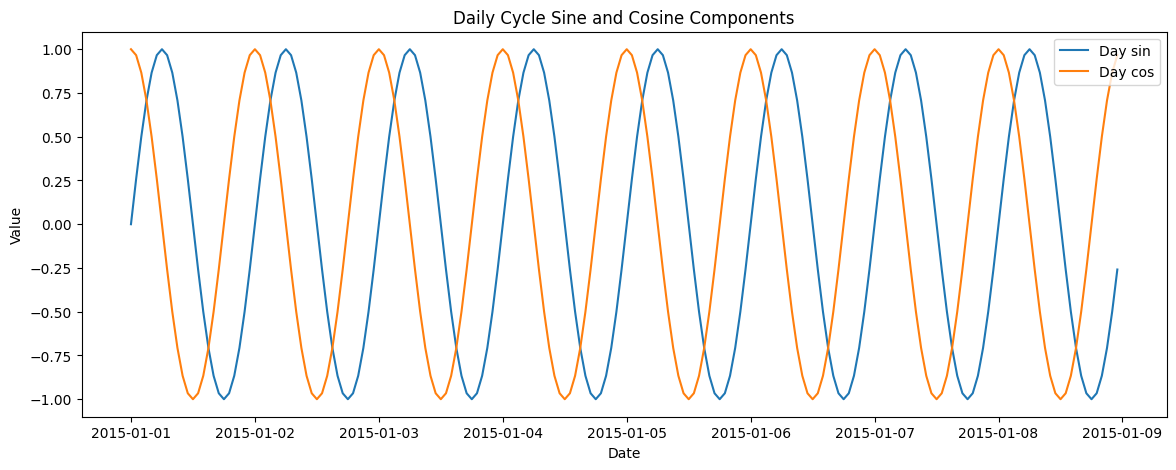

In [123]:
import matplotlib.pyplot as plt

# Overlaying the Day sin and Day cos over a selected week
subset = USW00013985_hourly.loc['2015-01-01' : '2015-01-08']

plt.figure(figsize=(14, 5))
plt.plot(subset.index, subset['Day sin'], label='Day sin')
plt.plot(subset.index, subset['Day cos'], label='Day cos')
plt.title('Daily Cycle Sine and Cosine Components')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


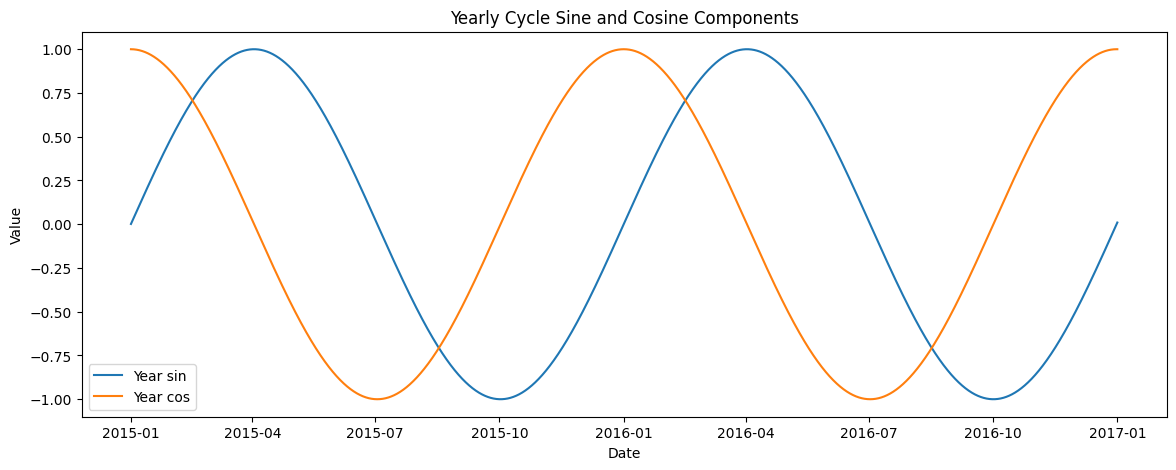

In [124]:
# Select a year's data
subset = USW00013985_hourly.loc['2015-01-01' : '2016-12-31']

plt.figure(figsize=(14, 5))
plt.plot(subset.index, subset['Year sin'], label='Year sin')
plt.plot(subset.index, subset['Year cos'], label='Year cos')
plt.title('Yearly Cycle Sine and Cosine Components')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [125]:
# Number of samples
# Extract the temperature data
temperature = USW00013985_hourly['temperature'].dropna()

# Number of samples
n_samples = len(temperature)

# Sampling rate (samples per hour)
sampling_rate = 1  # Assuming hourly data

# Compute the FFT of the temperature data
fft_vals = np.fft.rfft(temperature)

# Frequencies associated with the FFT components
freqs = np.fft.rfftfreq(n_samples, d=1/sampling_rate)

# Convert frequencies to cycles per year
hours_per_year = 24 * 365.2425
freqs_per_year = freqs * sampling_rate * (hours_per_year / n_samples)



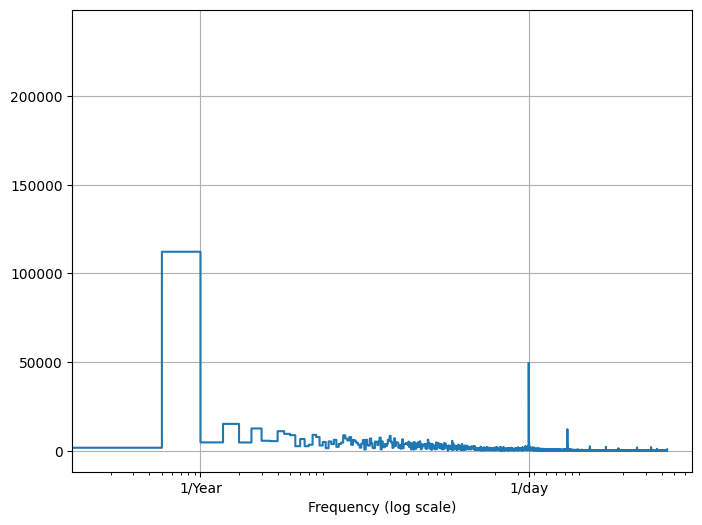

In [127]:
fft = tf.signal.rfft(USW00013985_hourly['temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(USW00013985_hourly['temperature'])
hours_per_year = 24*365.5 # 2016 is a leap year, only using 2015, 2016
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.xlabel('Frequency (log scale)')
plt.grid(True)
plt.show()

# Split the data

In [128]:
# Let's assume your processed DataFrame is called 'USW00013985_hourly'
df = USW00013985_hourly.copy()
# Sort the DataFrame by datetime index
df = df.sort_index()


In [129]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [130]:
print(f"Total samples: {n}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Total samples: 17544
Training samples: 12280
Validation samples: 3509
Test samples: 1755


In [131]:
num_features = df.shape[1]
print(f"Number of features: {num_features}")


Number of features: 16


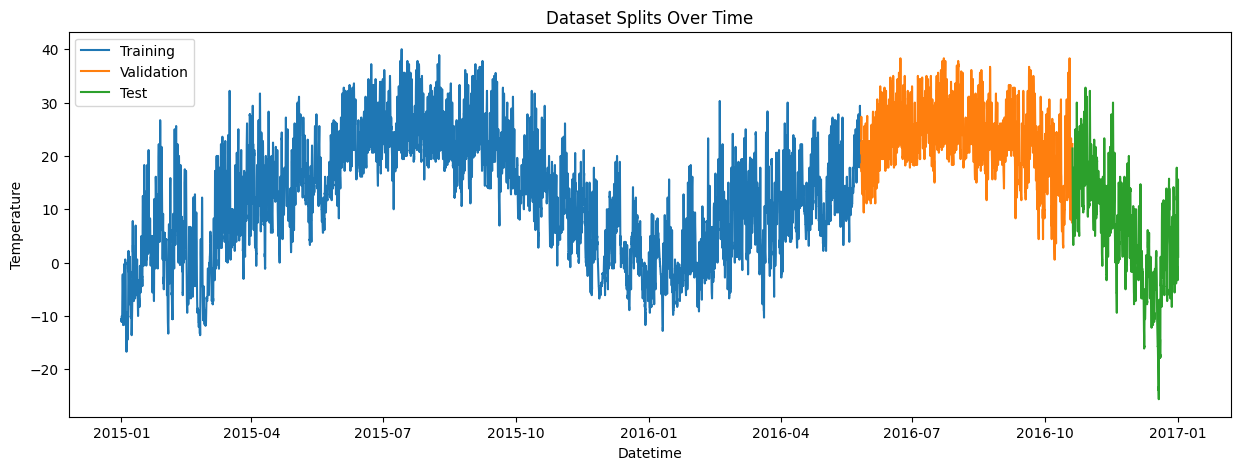

In [132]:
import matplotlib.pyplot as plt

# Plot an example feature over time, highlighting the splits
plt.figure(figsize=(15, 5))
plt.plot(train_df.index, train_df['temperature'], label='Training')
plt.plot(val_df.index, val_df['temperature'], label='Validation')
plt.plot(test_df.index, test_df['temperature'], label='Test')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.title('Dataset Splits Over Time')
plt.show()


# 5-scaling-and-normalizing-the-data

In [133]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


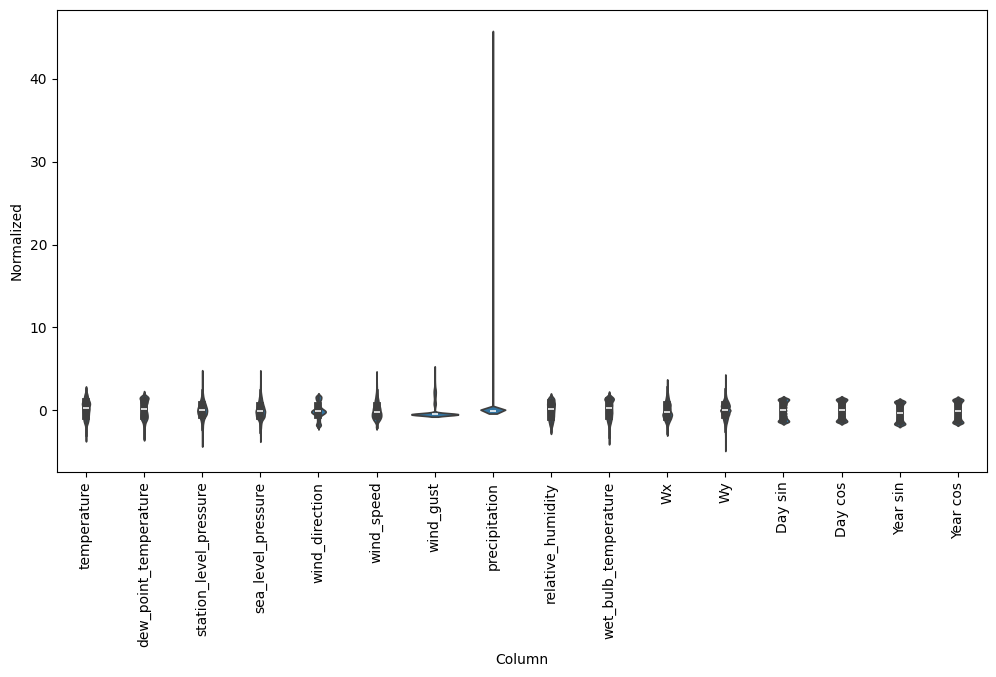

In [134]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [135]:
# Get the top 10 rows with the highest 'precipitation' values
top_10_precipitation = df.nlargest(10, 'precipitation')
print(top_10_precipitation)


                     temperature  dew_point_temperature  \
Datetime                                                  
2016-04-16 13:00:00    12.600000              12.116667   
2015-06-12 08:00:00    15.800000              15.600000   
2016-07-03 02:00:00    20.383333              19.233333   
2016-08-07 07:00:00    19.550000              18.700000   
2016-07-02 07:00:00    18.180000              18.180000   
2015-05-28 02:00:00    17.500000              15.000000   
2015-05-25 07:00:00    12.375000              10.062500   
2015-05-25 05:00:00    12.683333              11.616667   
2015-05-17 00:00:00    12.516667              10.483333   
2016-05-24 23:00:00    22.325000              20.750000   

                     station_level_pressure  sea_level_pressure  \
Datetime                                                          
2016-04-16 13:00:00              918.000000         1006.906667   
2015-06-12 08:00:00              921.480000         1009.806667   
2016-07-03 02:00:00    

# 5-saving-new-data-file

In [ ]:
# Define the file path
file_path = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv'

# Save the DataFrame to the specified path
USW00013985.to_csv(file_path, index=False)